In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

### Not important plotting helper function

In [2]:
def dynamic_plotting(samples):
    plt.ion()

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 3

    fig1 = plt.figure(1)
    ax1_1 = fig1.add_subplot(121)
    fig1.canvas.draw()

    z= 100
    b = np.ones([1])

    for i in range(z):
        # update data 
        b = np.append(b, [samples[i*100:(i+1)*100]])
    
        # re-plot area 1 of fig1  
        ax1_1.clear()
        ax1_1.set_xlim (0, 10000)
        ax1_1.set_ylim (0, 1)
        ax1_1.plot(b)
    
        # redraw fig 1 
        fig1.canvas.draw()

# Define Probabilities

**Learn how the author deinfes probabilities in dictionaries for specific problem.**

In [3]:
prob_type = 0.25
prob_region = 0.55
prob_prod = {(1,1): 0.9, (1,0): 0.75, (0,1):0.8, (0,0):0.6}
prob_usage= {(1,): 0.5, (0,): 0.3}
prob_price = {(1,): 0.3, (0,): 0.6}
prob_cancel = {(1,1): 0.4, (1,0): 0.2, (0,1): 0.25, (0,0): 0.1}


# The last to lines are dictionary that enables building a computational graph
# In reject sampling, it is no used yet.
prob = {0: prob_type, 1: prob_region, 2: prob_prod, 3: prob_usage, 4: prob_price, 5: prob_cancel}
dep = {0: 'no', 1: 'no', 2: [0,1], 3: [2], 4: [3], 5: [3,4]}

# Reject Sampling

**Use Tuple as dictionary keys, you need to know:**                                       
https://docs.python.org/3/faq/design.html#why-are-there-separate-tuple-and-list-data-types

The hash table implementation of dictionaries uses a hash value calculated from the key value to find the key. If the key were a mutable object, its value could change, and thus its hash could also change. But since whoever changes the key object can’t tell that it was being used as a dictionary key, it can’t move the entry around in the dictionary. Then, when you try to look up the same object in the dictionary it won’t be found because its hash value is different. If you tried to look up the old value it wouldn’t be found either, because the value of the object found in that hash bin would be different.

If you want a dictionary indexed with a list, simply convert the list to a tuple first; the function tuple(L) creates a tuple with the same entries as the list L. Tuples are immutable and can therefore be used as dictionary keys.

In [4]:
samples = []
samples.append(0)

accept_count = 0
reject_count = 0

for i in range(10000):
    # 1 for hospital, 0 for Doctor's office
    t = np.random.choice([1,0], p = [prob_type, 1 - prob_type])
    
    # 1 for north, 0 for south
    r = np.random.choice([1,0], p = [prob_region, 1 - prob_region])
    
    # 1 for one product, 0 for two or more products
    p = np.random.choice([1,0], p = [prob_prod[(t,r)], 1 - prob_prod[(t,r)]])
    
    # 1 for low usage, 0 for high usage
    u = np.random.choice([1,0], p = [prob_usage[(p,)], 1 - prob_usage[(p,)]])
    
    # 1 for price increase, 0 for no price increase
    pr = np.random.choice([1,0], p = [prob_price[(u,)], 1 - prob_price[(u,)]])
    
    # 1 for cancel, 0 for not cancel
    c = np.random.choice([1,0], p = [prob_cancel[(u,pr)], 1 - prob_cancel[(u,pr)]])
    
    # since we want P(cancel |r = north)
    if r == 0:
        reject_count += 1
        
    else:
        avg = (samples[accept_count] * accept_count + c) / (accept_count + 1)
        samples.append(avg)
        accept_count += 1
        # here we don't store sampled values, we store our belief
        
        

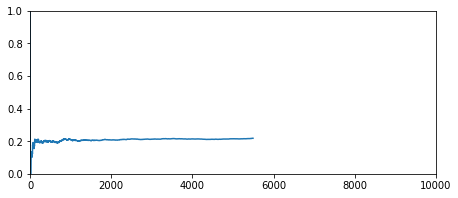

In [5]:
dynamic_plotting(samples)

In [6]:
print(samples[-1])

print("Proportion of samples rejected: {}".format(reject_count/10000))
print("Conditional probability with rejection sampling: {}".format(samples[9999-reject_count]))

0.21777130371449377
Proportion of samples rejected: 0.4508
Conditional probability with rejection sampling: 0.21781096339464573


### 知识点：Dynamic update Average, Probabilities within one piece of business code.

#### If we want to update mean                

Suppose we have a dictionary of means, each value is updated from its previous element.    
You update a value with previous mean and current value.     

now comes a new sample with value = `value`:            

Since we know             
```python
avg = sums / count
```

Now we update average `avg`              
```python
new_count = count + 1
new_sums = count* avg + value
new_avg = new_sums / new_count
new_avg = (count * avg) / (count + 1)
```

#### If we want to update a probability             

*Now we have a list of probabilities [values between 0 and 1]*    

Since we know
```python
prob = success / trials
```

Now comes a new value, that is either 0 or 1, 0 for failed, 1 for success.       

```python
new_success = trials *  prob +  value
new_trails = trials + 1
new_prob = (trials * prob) +  value / (trials + 1)
```

所以作者省去了存储一堆0和1， 只存储我当前的belief， 一段合格的工程代码。                  
当我们使用Epsilon Greddy 算法的时候，这个就特别有用了。                              

In [7]:
prob = {0: prob_type, 1: prob_region, 2: prob_prod, 3: prob_usage, 4: prob_price, 5: prob_cancel}
dep = {0: 'no', 1: 'no', 2: [0,1], 3: [2], 4: [3], 5: [3,4]}

In [8]:
# there are 6 vairables
variable = set(np.arange(6))

# the 2nd variable is the given variable
given = set([1])

# other variables are free
free_var = list(variable.difference(given))

# randomly pick a sample.
val = np.array([1,1,1,1,1,1])

In [9]:
samples = list()

# append the 1st result from the 1st sample
samples.append(val[5])

for i in range(10000):
    
    # randomly choose a free variable
    var = np.random.choice(free_var)
    
    # if this variable has no parent variable
    # the variable can be drawn with its own probability distribution
    if dep[var]=='no':
        var_prob = prob[var]
        
    # if the variable has parent variable
    # find the current value of all the parent variables
    # find the probability of the current variable
    else:
        var_prob = prob[var][tuple(val[dep[var]])]
        
    # randomly draw a sample of the current variable
    rand = np.random.uniform()
    if rand <= var_prob:
        new_val = 1
    else:
        new_val = 0
    
    # set the value of current variable with new sampled value
    val[var] = new_val
    
    # now I have i samples, update probability
    avg = (samples[i]*i+val[5])/(i+1)
    samples.append(avg)

### Review course 
Suppose we have a graph like that

In [229]:
import networkx as nx

class ProbGraph():
    
    
    def __init__(self, edgelist):
        '''Initialize a Bayesian graph'''
        self.edgelist = edgelist
        self.G = nx.from_edgelist(self.edgelist, create_using=nx.DiGraph)
        
        
    def _draw_graph(self,G):
        '''Simple graph draw function'''
        layout = nx.spring_layout(G)
        fig, ax = plt.subplots(figsize = (8,6))
        nx.draw(G, with_labels = True, alpha = 0.8, node_size= 1000, pos = layout)
        plt.show()
        
        
    def get_graph(self):
        '''Return the networkx graph'''
        return self.G
    
    
    def draw_full_graph(self):
        '''Draw full bayesian network'''
        self._draw_graph(self.G)
       
    
    def markov_linkage(self, n):
        '''Get markov linkage, which is a subgraph of the bayesian network'''
        # find all childrens of a node
        childs = list(self.G.successors(n))
        
        # find all parents of a node
        parents = list(self.G.predecessors(n))
        
        # find all parents of all childs of n
        childs_parents = [list(self.G.predecessors(c)) for c in childs]
        childs_parents = [n for l in childs_parents for n in l]
        
        # make a subgraph
        subnodes = list(set(childs + parents + childs_parents + [n]))
        subG = self.G.subgraph(subnodes)
        return subG
    
    
    def draw_markov_linkage(self,n):
        '''Draw markov linkage on a give node n'''
        subG = self.markov_linkage(n)
        self._draw_graph(subG)
        
        
    def D_separate(self, joints, givens = None):
        
        '''Preform d-separation'''
        
        givens = givens if givens else []

        # find all variables mentioned
        variables = givens + joints
        subsets = []

        # loop through variables, find parents and parents of parenets
        for variable in variables:
            all_edges = list(nx.edge_dfs(G,variable, orientation='reverse'))
            subset = [[s,t] for s,t, _ in all_edges]
            subsets.append([n for l in subset for n in l])
            
        # subset should also include original variables, but exclude
        subsets = list(set([n for l in subsets for n in l]).union(joints))

        # constract ancestral graph A
        A = nx.DiGraph(G.subgraph(subsets))

        # for all nodes in A, connect parents of joint childs
        for node in A.nodes():
            predecessors = list(A.predecessors(node))
            if len(predecessors) >=2:
                for u,v in list(combinations(predecessors,2)):
                    A.add_edge(u,v)

        # unorient the graph 
        A = nx.Graph(A)

        # remove the givens
        subsets = [n for n in A.nodes() if n not in givens]

        A = nx.Graph(A.subgraph(subsets))
        
        return A

**Initialize and darw a graph**

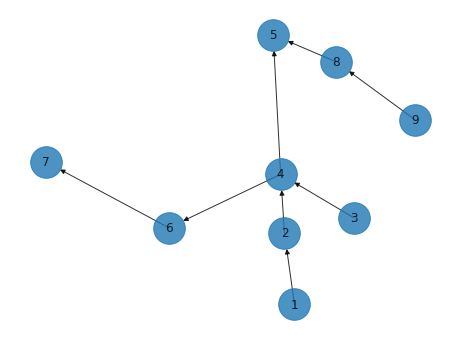

In [232]:
edge_list = [[1,2],[2,4],[3,4],[4,5],[4,6],[6,7],[8,5],[9,8]]
PGraph = ProbGraph(edge_list)
PGraph.draw_full_graph()

**Node 4 is the only child of node 3**        
**Node 4 has another parent 2**     
**Markov linkage include nodes $N = \{2,3,4\}$**

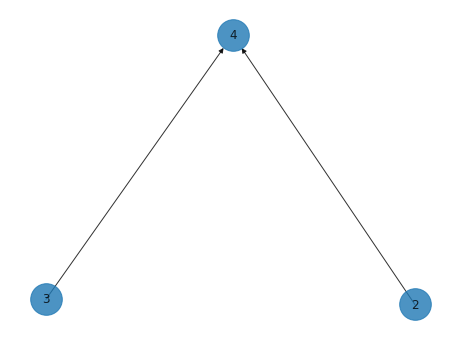

In [223]:
PGraph.draw_markov_linkage(3)

**Node 6 has a parent 4 and a son 7**
**Markov linkage include nodes $N = \{4,6,7\}$**

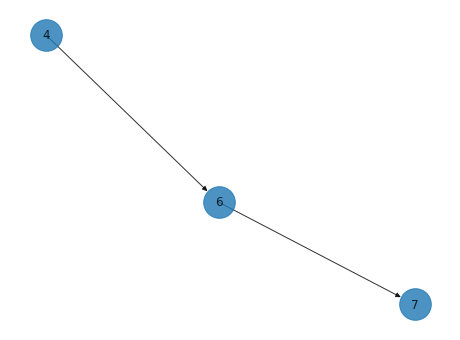

In [224]:
PGraph.draw_markov_linkage(6)

**Test on another graph**

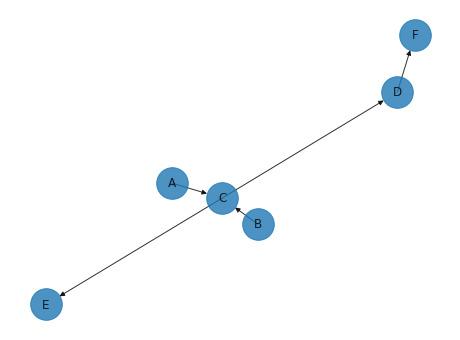

In [225]:
edge_list = [['A','C'],['B','C'],['C','D'],['C','E'],['D','F']]
PGraph = ProbGraph(edge_list)
PGraph.draw_full_graph()

*C has parents A and B, children D, E, which have no other parents*
*$N = \{A,B,C,D,E\}$*

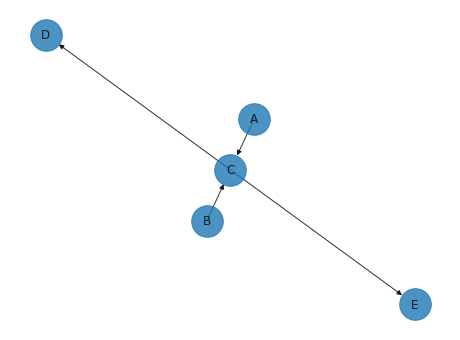

In [226]:
PGraph.draw_markov_linkage('C')

**Next we do D-separation**

In [227]:
edge_list = [['A','C'],['B','C'],['C','D'],['C','E'],['D','F']]
G = nx.from_edgelist(edge_list, create_using=nx.DiGraph)

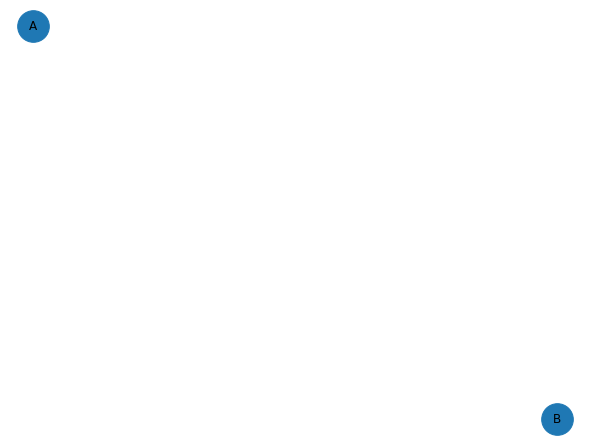

In [228]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['A','B'])

nx.draw(A, with_labels = True, node_size = 1000)

**There's not edge between A & B, we say A and B are absolutely independent**

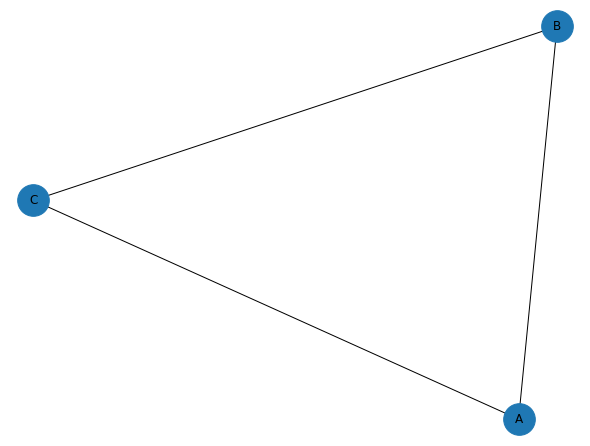

In [234]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['A','B'],givens =  ['D','F'])

nx.draw(A, with_labels = True, node_size = 1000)

**There is an edge between A and B, A and B are not required to be independent give D and F**

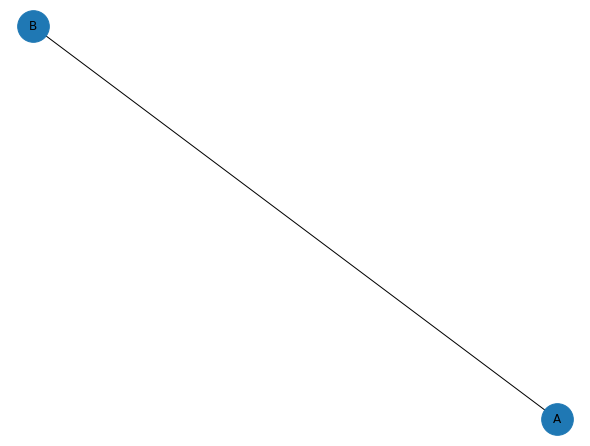

In [235]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['A','B'],givens =  ['C'])

nx.draw(A, with_labels = True, node_size = 1000)

**Has edge: A and B are not required to be indepndent give C**

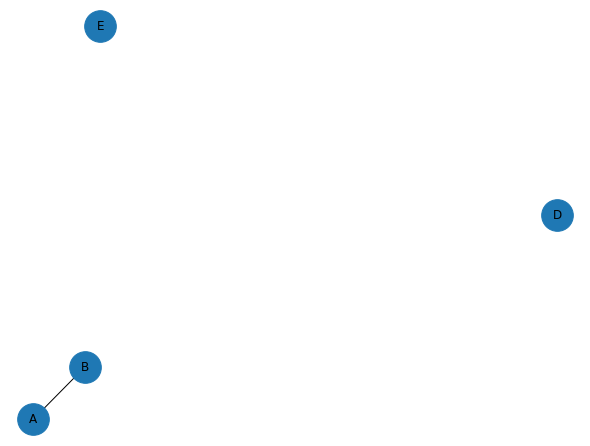

In [236]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['D','E'],givens =  ['C'])

nx.draw(A, with_labels = True, node_size = 1000)

**D and E are conditionally independent give C**

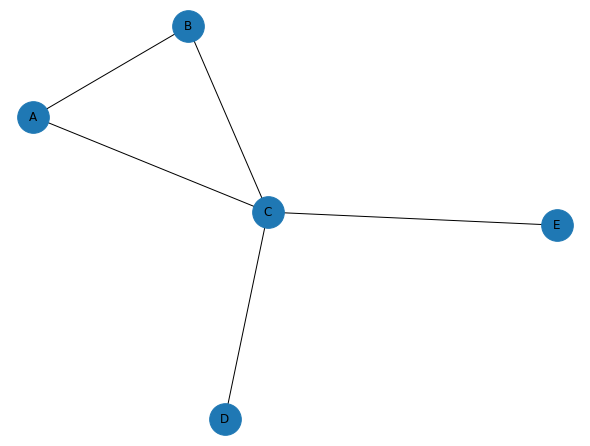

In [237]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['D','E'])

nx.draw(A, with_labels = True, node_size = 1000)

**D and E are connected through C, they are not absolute indendent**

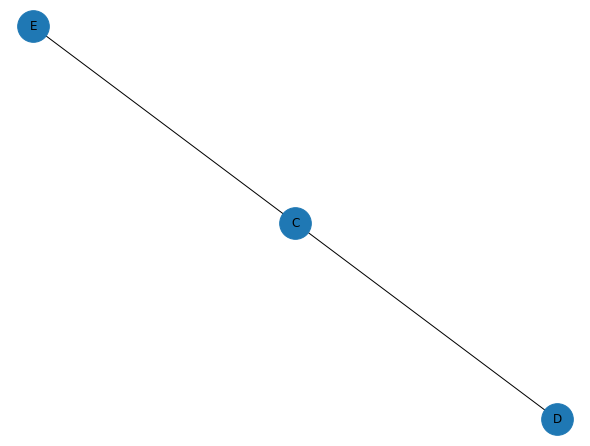

In [238]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['D','E'],givens = ['A','B'])

nx.draw(A, with_labels = True, node_size = 1000)

**Given A, and B, DE are connected through C, not conditionally indepndent**

All the tests are passed, haha

**There are still more complex cases that are not considered yet. TO BE IMPLEMENTED...**

## Gibbs sampling review

**Firstly, we want to review the probability tables, in a real world, we're not going to represent everthing as 0 and 1, because the events are hard to recognize and review in code**

In [239]:
prob_type = 0.25
prob_region = 0.55
prob_prod = {(1,1): 0.9, (1,0): 0.75, (0,1):0.8, (0,0):0.6}
prob_usage= {(1,): 0.5, (0,): 0.3}
prob_price = {(1,): 0.3, (0,): 0.6}
prob_cancel = {(1,1): 0.4, (1,0): 0.2, (0,1): 0.25, (0,0): 0.1}
prob = {0: prob_type, 1: prob_region, 2: prob_prod, 3: prob_usage, 4: prob_price, 5: prob_cancel}

In [245]:
# these 2 things are extreamly simple
prob_type = 0.25
prob_region = 0.55

# yet a distribution is prefered
prob_type = {'Hospical':0.25, 'DO':0.75}
prob_region = {'North':0.55, 'South':0.45}



**As long as we find a joint child, we need to define a <font color = 'red'>Cartesian Product of its parents, as well as all possible values of this node</font>**

**Or to say <font color = 'red'> Conditional Probability Distribution (CPD)</font>**

In [272]:
import pandas as pd
import itertools

In [281]:
parents = [prob_type, prob_region]
column_names = ['Type','Region']
potential_values = ['=1','>=2']
keys = [list(p.keys()) for p in parents] + [potential_values]
table = pd.DataFrame(list(itertools.product(*keys)), columns = column_names + ['NProducts'])
table['probability'] = 0
table

,Type,Region,NProducts,probability
0,Hospical,North,=1,0
1,Hospical,North,>=2,0
2,Hospical,South,=1,0
3,Hospical,South,>=2,0
4,DO,North,=1,0
5,DO,North,>=2,0
6,DO,South,=1,0
7,DO,South,>=2,0


*The probabilities are zeros, which are not correct, and should be inferred from observed data.*

In [300]:
y

0.0

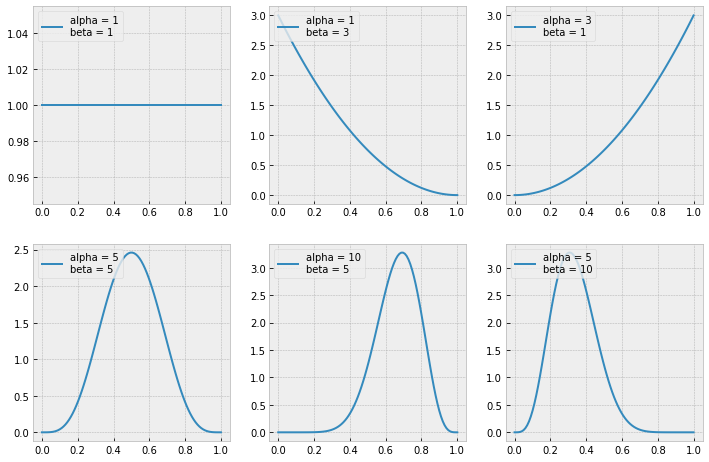

In [298]:
from IPython.core.pylabtools import figsize
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('bmh')

alphas = [1,1,3,5,10,5]
betas = [1,3,1,5,5,10]


x = np.linspace(0,1,100)

figsize(12,8)
i = 1
for alpha, beta in zip(alphas, betas):
    plt.subplot(2,3,i)
    y = stats.beta.pdf(x, alpha, beta)
    plt.plot(x,y,label = 'alpha = {}\nbeta = {}'.format(alpha, beta))
    plt.legend(loc= 'upper left')
    i+=1
plt.show()
    

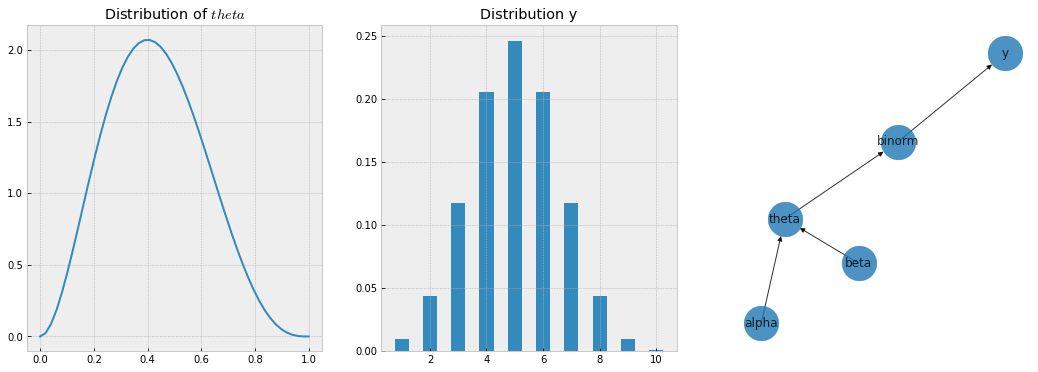

In [344]:
figsize(18,6)

plt.subplot(1,3,1)
x = np.linspace(0,1,50)
y = stats.beta(3,4).pdf(x) 
plt.plot(x,y)
plt.title('Distribution of $theta$')
plt.subplot(1,3,2)
x = [1,2,3,4,5,6,7,8,9,10]
y = stats.binom(10,0.5).pmf(x)
plt.bar(x,y,width = 0.5)
plt.title('Distribution y')
plt.subplot(1,3,3)
nx.draw(nx.from_edgelist(edgelist,create_using=nx.DiGraph),with_labels = True, node_size = 1200, alpha = 0.8)
plt.show()

### Metropolis Hasting

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [32]:
data = np.random.randn(20)

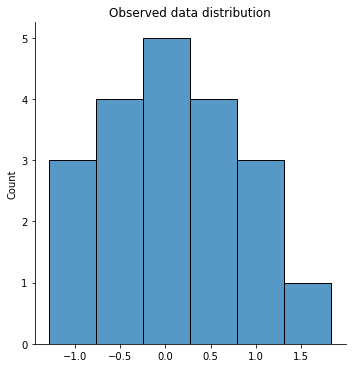

In [36]:
sns.displot(data)
plt.title('Observed data distribution')
plt.show()

Assume the likelihood of the data is normal.    
Assume the prior = assuming the parameters we know (Assume the parameter mu is normally distributed).   
Normal distribution is a conjugate prior of normal distribution.   

$\mu \sim Normal(0,1)$                           
$x|\mu  \sim Normal(\mu,1)$     
${Want}: \mu|x$


Easy? YOU NEED THIS PAPER.                  
https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM    

**BELIEVE ME, YOU DONT WNAT TO GIVE IT A TRY**

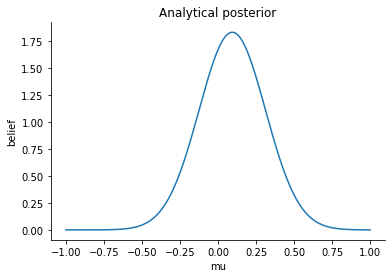

In [38]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    
    ### THAT IS FOR FORMULA, DO YOU WANT TO GIVE IT A TRY?   
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

In [52]:
mu_prior_mu = 1
mu_prior_std = 1

You will notice that the likelihood is very small

In [59]:
mu_current = 1
proposal_width = 0.5

proposal = norm(mu_current,proposal_width).rvs()
print(f'I have a proposal mu = {proposal}')

# this is actually maximum likelihood
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(proposal, 1).pdf(data).prod()
print('Likelihood of current {}'.format(log_likelihood_current))
print('Likelihood of proposal {}'.format(log_likelihood_proposal))

prior_current = norm(mu_prior_mu, mu_prior_std).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_std).pdf(proposal)
print('Prior current {}'.format(prior_current))
print('Prior proposal {}'.format(prior_proposal))

posterior_current = likelihood_current * prior_current
posterior_proposal = likelihood_proposal * prior_proposal
print('Posterior current {}'.format(posterior_current))
print('Posterior proposal {}'.format(posterior_proposal))

I have a proposal mu = 0.9041062613101382
Likelihood of current 5.3892600998880065e-15
Likelihood of proposal 3.2656807931545436e-13
Prior current 0.3989422804014327
Prior proposal 0.39711223209157875
Posterior current 2.150003713925774e-15
Posterior proposal 1.0993853679325448e-14


In [89]:
from scipy.stats import bernoulli
np.random.seed(123)
n_experiments = 20
theta_true = 0.35

data = bernoulli(theta_true).rvs(size = n_experiments)

$\theta \sim Beta(1,1)$     
$y|\theta \sim Binom(n = 1, p = \theta)$

In [95]:
data.mean()

0.3

In [90]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [97]:
with pm.Model() as model:
    theta = pm.Beta(name = "theta", alpha = 1, beta = 1)
    y = pm.Bernoulli(name = 'y',p = theta, observed = data)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000,step = step,return_inferencedata=True,start = start)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


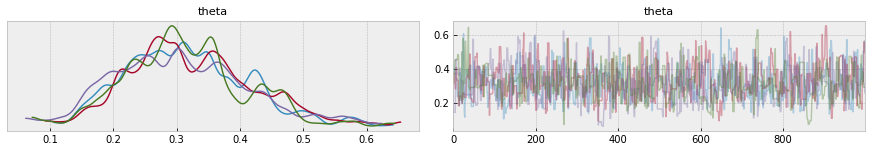

In [98]:

az.plot_trace(trace)
plt.show()

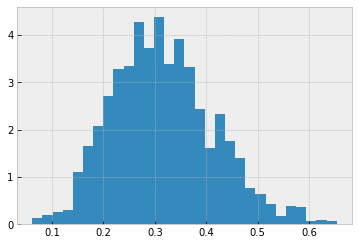

In [99]:
plt.hist(trace.posterior['theta'].values.reshape(-1), bins = 30,density = True)
plt.show()

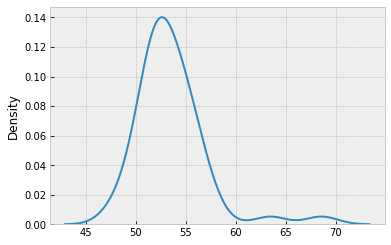

In [104]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45,
   52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33,
   57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
   51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99,
   52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84,
   53.16])

sns.kdeplot(data)
plt.show()

In [110]:
with pm.Model() as model:
    mu = pm.Uniform('mu',40,60)
    sigma = pm.HalfNormal('sigma',10)
    obs= pm.Normal('observed', mu, sigma, observed = data)
    trace = pm.sample(2000,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


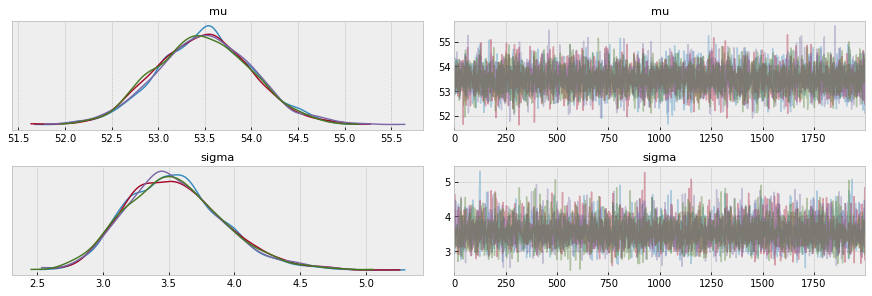

In [111]:
az.plot_trace(trace)
plt.show()

In [122]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,53.494,0.516,52.541,54.474,0.006,0.004,7185.0,7183.0,7204.0,5343.0,1.0
sigma,3.548,0.374,2.899,4.286,0.005,0.003,6403.0,6237.0,6572.0,5482.0,1.0


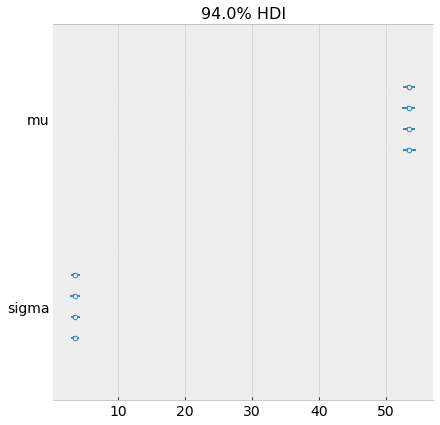

In [130]:
az.plot_forest(trace)
plt.show()

In [165]:
with model:
     y_pred = pm.sample_posterior_predictive(
        trace, 100, random_seed=123
    )

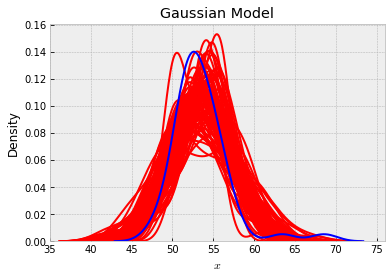

In [169]:
for i in y_pred['observed']:
    sns.kdeplot(i, c = 'r', alpha = 0.01)
sns.kdeplot(data, c = 'b')
plt.xlim(35,76)
plt.xlabel('$x$')
plt.title('Gaussian Model')
plt.show()

### I don't really know what I am thinking about

In [185]:
import pandas as pd
import numpy as np

In [186]:
def get_variable(n_categories = 3, size = 10, prefix = 'a'):
    a = np.random.randint(1,n_categories + 1, size = size)
    return ['{}_{}'.format(prefix, i) for i in a]

In [192]:
n_points = 1000
a = get_variable(3,n_points,'a')
b = get_variable(2,n_points,'b')
c = get_variable(4,n_points,'c')

In [193]:
df = pd.DataFrame({'a':a, 'b':b,'c':c})

### Step 1: counting variables

In [207]:
def joint_distribution(df, variables = ['a','b','c'],normalize = True):
    jnt_df = df.groupby(variables).apply(lambda x:len(x)).reset_index()
    jnt_df.columns = list(variables) + ['count']
    if normalize:
        jnt_df['count'] = jnt_df['count'] / len(df)
        jnt_df.rename(columns = {'count':'prob'}, inplace = True)
    return jnt_df

In [209]:
joint_distribution(df).head()

,a,b,c,prob
0,a_1,b_1,c_1,0.044
1,a_1,b_1,c_2,0.038
2,a_1,b_1,c_3,0.045
3,a_1,b_1,c_4,0.039
4,a_1,b_2,c_1,0.040


In [223]:
np.sum([[True,True,False],[True,True,True],[False, True, True]],axis = 0) == 3

array([False,  True, False])

### Continue mcmc

In [37]:
import seaborn as sns
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
from IPython.core.pylabtools import figsize
plt.style.use('bmh')

In [19]:
tips = pd.read_csv('tips.csv')

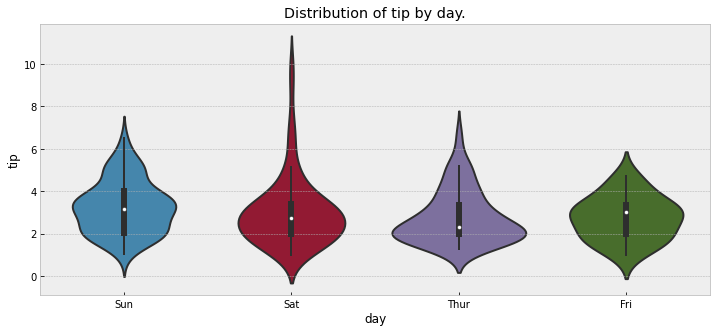

In [22]:
figsize(12,5)
sns.violinplot(x = 'day', y = 'tip', data = tips)
plt.title('Distribution of tip by day.')
plt.show()

In [30]:
idx = pd.Categorical(tips.day).codes
x = np.array(list(set(idx)))

In [51]:
with pm.Model() as model:
    means = pm.Normal('means', mu = 0, sd = 10, shape = len(x))
    sds = pm.HalfNormal('sds', sd = 10, shape = len(x))
    y = pm.Normal('y',means[idx], sds[idx], observed = tips['tip'].values)
    trace = pm.sample(5000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sds, means]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.


<AxesSubplot:>

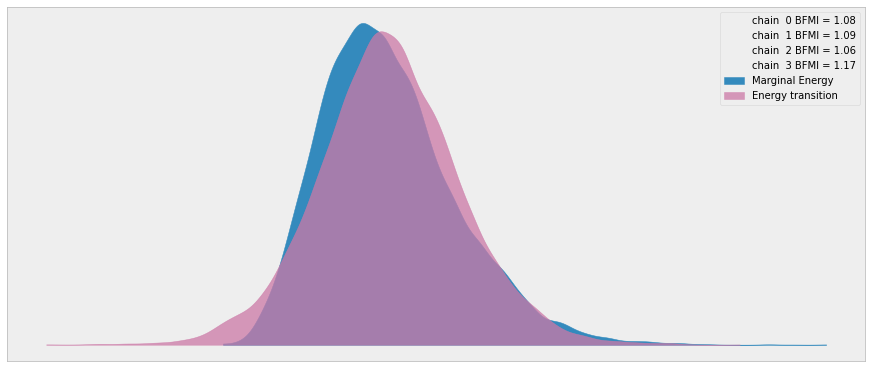

In [56]:
az.plot_energy(trace)

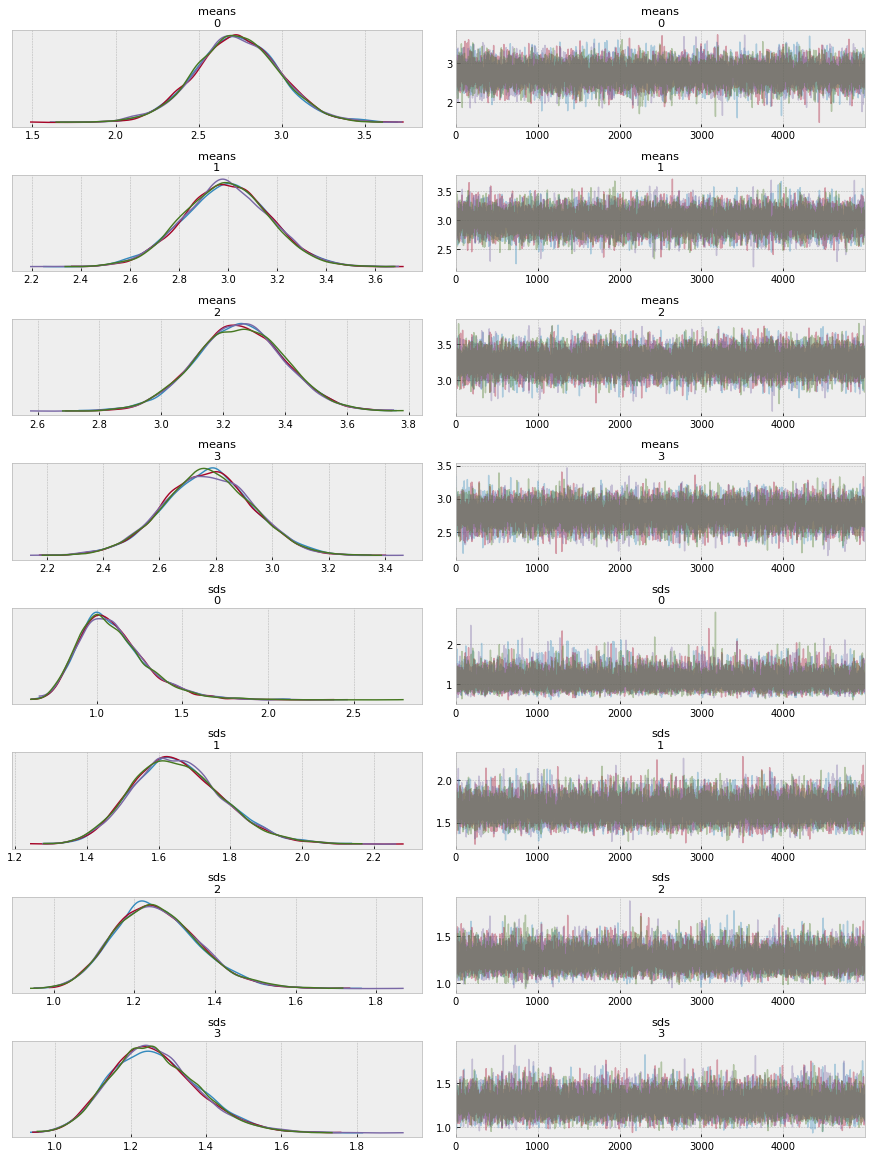

In [42]:
az.plot_trace(trace)
plt.show()

In [57]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],2.733,0.255,2.253,3.207,0.002,0.001,23914.0,23625.0,24115.0,15480.0,1.0
means[1],2.992,0.177,2.652,3.317,0.001,0.001,27000.0,26980.0,26995.0,16340.0,1.0
means[2],3.255,0.144,2.981,3.525,0.001,0.001,23403.0,23403.0,23392.0,16076.0,1.0
means[3],2.771,0.161,2.469,3.074,0.001,0.001,21056.0,21030.0,21083.0,16288.0,1.0
sds[0],1.098,0.203,0.760,1.480,0.002,0.001,18034.0,16454.0,20053.0,14943.0,1.0
sds[1],1.654,0.128,1.414,1.886,0.001,0.001,24182.0,23551.0,24876.0,16311.0,1.0
sds[2],1.256,0.104,1.071,1.455,0.001,0.000,25498.0,24840.0,26120.0,16917.0,1.0
sds[3],1.267,0.117,1.054,1.488,0.001,0.001,22026.0,21374.0,22759.0,15797.0,1.0


In [61]:
from scipy import stats

In [62]:

np.random.seed(123)
n_experiments = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
print(data)

[1 0 0 0]


In [63]:
with pm.Model() as model:
    theta = pm.Beta('theta',1,1)
    obs = pm.Bernoulli('obs', theta, observed = data)
    trace = pm.sample(1000)

/Users/huan/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [64]:
trace[100:]

<MultiTrace: 4 chains, 900 iterations, 2 variables>

/Users/huan/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/huan/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/traceplot.py:212: UserWarning: A valid var_name should be provided, found {'t'} expected from {'theta'}
  warnings.warn(


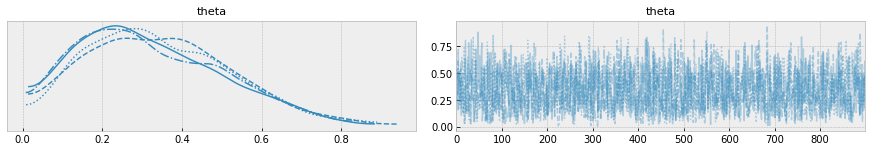

In [71]:
pm.traceplot(trace[100:],lines ={'theta': theta_real})
plt.show()

/Users/huan/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


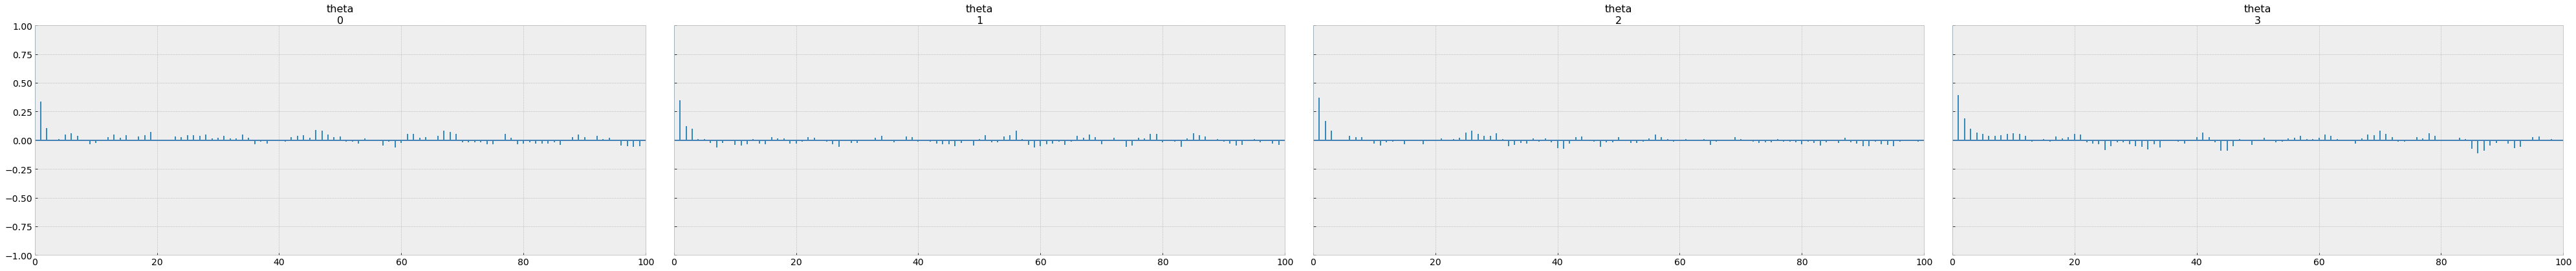

In [74]:
pm.autocorrplot(trace)
plt.show()

/Users/huan/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

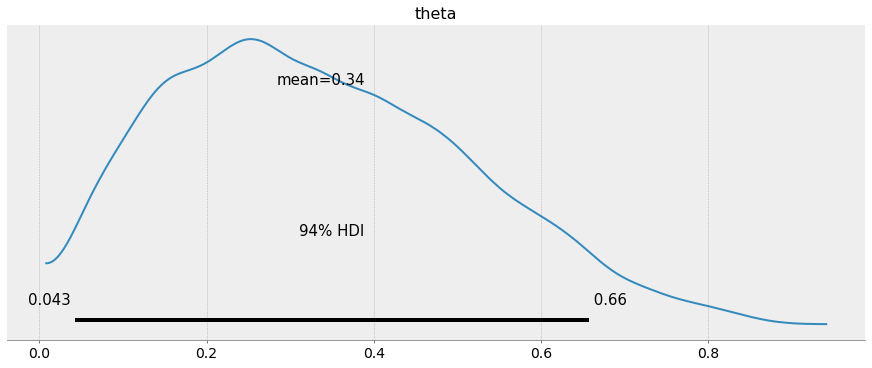

In [75]:
pm.plot_posterior(trace)